Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
tf.__version__
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping




Importing the Dataset

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
image_folder = r"C:\Users\91897\Desktop\CP302\Data\Speckle Images\C_4\Set2\Center"
csv_file = r"C:\Users\91897\Desktop\CP302\EDA and Feature Engineering\Center Results\Yi's_Center.csv"


# Loading Y(Mean Speckle Contrast) values from CSV
df = pd.read_csv(csv_file)
Y_values = df.iloc[1:93,19].values.astype(float)  # Taking corresponding Mean  column from row 3 to 92 (90 values)
Y = [f"{value:.4f}" for value in Y_values] #Rounding off numbers to 4 decimal points.
print('Mean Speckle Contrast values [Y]: ', Y)
print('Number of Mean Speckle contrast values : ',len(Y))

Mean Speckle Contrast values [Y]:  ['0.4138', '0.4102', '0.4139', '0.4055', '0.4118', '0.4243', '0.4001', '0.4606', '0.4243', '0.4241', '0.4089', '0.4263', '0.4104', '0.3902', '0.4102', '0.4381', '0.4213', '0.4215', '0.4413', '0.4120', '0.4187', '0.4180', '0.4046', '0.4189', '0.4059', '0.3859', '0.4200', '0.4300', '0.4044', '0.4057', '0.4065', '0.3959', '0.4070', '0.4216', '0.3988', '0.3885', '0.3868', '0.4050', '0.3864', '0.4015', '0.4106', '0.3938', '0.3804', '0.3744', '0.4160', '0.3858', '0.3754', '0.3666', '0.3667', '0.3958', '0.3712', '0.4052', '0.3749', '0.3690', '0.3912', '0.3905', '0.3875', '0.3671', '0.3835', '0.3801', '0.4136', '0.3928', '0.3800', '0.4086', '0.4023', '0.3621', '0.3797', '0.3895', '0.3749', '0.3990', '0.3996', '0.3511', '0.3878', '0.4154', '0.3950', '0.4114', '0.4356', '0.3959', '0.3773', '0.3648', '0.4122', '0.3870', '0.3909', '0.3741', '0.4097', '0.3894', '0.3728', '0.3924', '0.3749', '0.4024', '0.3990', '0.4138']
Number of Mean Speckle contrast values :  92

Data preprocessing

In [31]:
# Prepare input data X
X_values = []
for image_file in sorted(os.listdir(image_folder)):
    if image_file.endswith(".png"):  # Check if the file is a .png image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Loading as grayscale
        
        # Check if the image was successfully loaded
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue 
        
        # Resize the images for consistency
        img_resized = cv2.resize(img, (402,538))
        X_values.append(img_resized)

# Convert X & Y list to numpy array and reshape
X_values = np.array(X_values).reshape(-1,538,402, 1)  # Add a channel dimension
Y = np.array(Y_values).astype('float32')

print('Shape of input data X:', X_values.shape)
# Normalize pixel values
X_values = X_values.astype('float32') / 255.0  # Scale the pixel values
# Splitting data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_values, Y, test_size=0.2, random_state=42)


print('No of Image samples fed:',len(X_values))
print('Shape of X test:',X_test.shape)
print('Shape of X train:',X_train.shape)
# Reshaping y_train and y_test to have a single output column
y_train = y_train.reshape(-1, 1).astype('float32')
y_test = y_test.reshape(-1, 1).astype('float32')
print('Shape of y train:',y_train.shape)
#print(X_test)

Shape of input data X: (91, 538, 402, 1)
No of Image samples fed: 91
Shape of X test: (19, 538, 402, 1)
Shape of X train: (72, 538, 402, 1)
Shape of y train: (72, 1)


CNN Model

In [32]:
from tensorflow.keras.layers import BatchNormalization

# Custom R^2 metric for Keras
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Function to create CNN model for regression
def create_cnn(filters=32):
    model = Sequential()
    
    # Input layer (image size and 1 channel since grayscale)
    model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(538,402, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add more convolutional layers
    model.add(Conv2D(filters * 2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    # Output layer for regression (1 continuous value)
    model.add(Dense(1, activation='linear'))  # Linear activation for regression

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_keras])
    
    return model

# Create an instance of the CNN model
cnn_model = create_cnn(filters=32)

# Display the model summary
cnn_model.summary()

C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 536, 400, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 268, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 266, 198, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 133, 99, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 842688)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    53,932,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,950,977 (205.81 MB)

 Trainable params: 53,950,977 (205.81 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 1105.6770 - r2_keras: -3206557.5000 - val_loss: 4.1929 - val_r2_keras: -18723.5234
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 2.7118 - r2_keras: -6943.1323 - val_loss: 0.2692 - val_r2_keras: -1197.8341
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.2688 - r2_keras: -842.5109 - val_loss: 0.1766 - val_r2_keras: -792.8039
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.1000 - r2_keras: -246.2946 - val_loss: 0.0031 - val_r2_keras: -12.5384
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0168 - r2_keras: -69.9565 - val_loss: 0.0039 - val_r2_keras: -15.7756
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0075 - r2_keras: -27.1906 - val_loss: 0.0046 - val_r2_keras: -20.3505
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0066 - r2_keras: -23.3193 - val_loss: 0.0129 - val_r2_keras: -58.4480
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0104 - r2_keras: -25.7334 - 

Predictions on Testset

In [34]:
y_pred = cnn_model.predict(X_test)
np.set_printoptions(precision=4)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
[[0.3855 0.4106]
 [0.3855 0.4046]
 [0.3827 0.3905]
 [0.3777 0.3749]
 [0.385  0.4138]
 [0.3776 0.42  ]
 [0.369  0.4015]
 [0.3857 0.3797]
 [0.387  0.4089]
 [0.3838 0.416 ]
 [0.3842 0.3894]
 [0.374  0.3885]
 [0.3283 0.3996]
 [0.3639 0.38  ]
 [0.3736 0.4104]
 [0.3771 0.4118]
 [0.3672 0.4413]
 [0.3843 0.4044]
 [0.3701 0.3958]]


Performance metrics

In [35]:
from sklearn.metrics import mean_absolute_error
print('R2-score (test set): {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE(test set): ',mean_squared_error(y_test,y_pred))
print('MAE(test set): ',mean_absolute_error(y_test,y_pred))

R2-score (test set): -3.434
MSE(test set):  0.0011047706
MAE(test set):  0.02721715


Plot results

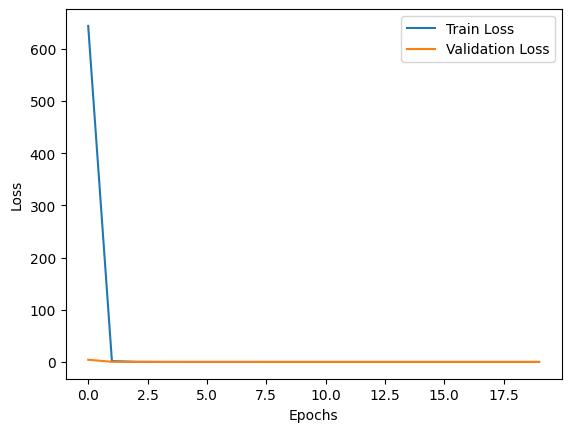

In [36]:
save_dir = r"C:\Users\91897\Desktop\CP302\ML Results\CNN\Center"
os.makedirs(save_dir, exist_ok=True)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(save_dir, 'Loss vs epochs_C4_set2_center.png'))
plt.show()

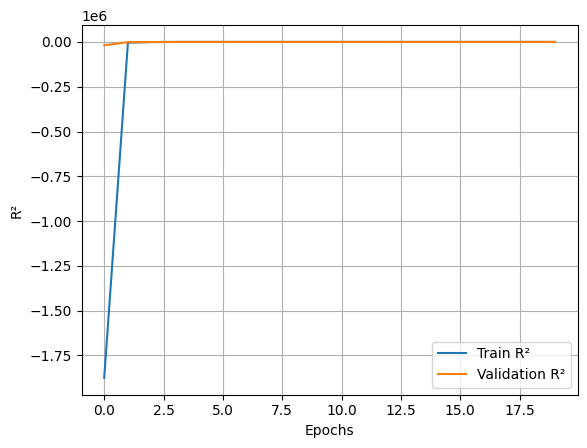

In [37]:
plt.plot(history.history['r2_keras'], label='Train R²')
plt.plot(history.history['val_r2_keras'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'R2_vs_Epochs_C4_set2_center.png'))
plt.show()

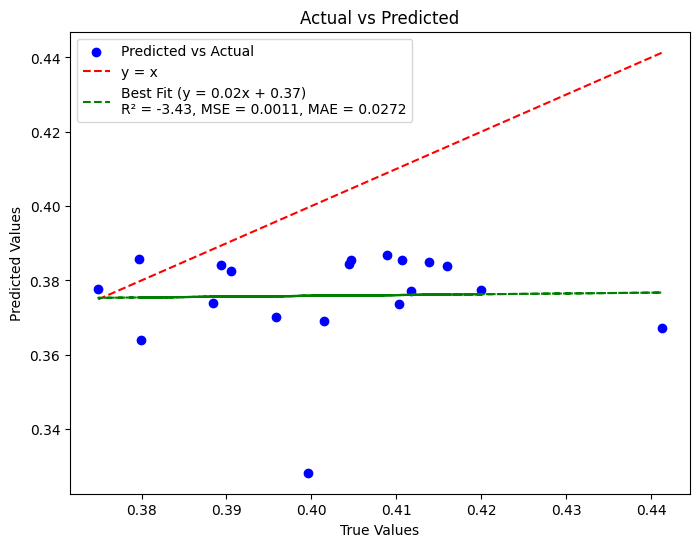

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Predicted vs Actual',color = 'blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y = x') #y=x line


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Best-fit line according to the plots(Regression)
slope, intercept = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)
best_fit_line = slope * y_test + intercept

plt.plot(y_test, best_fit_line, 'g--', 
         label=f'Best Fit (y = {slope:.2f}x + {intercept:.2f})\nR² = {r2:.2f}, MSE = {mse:.4f}, MAE = {mae:.4f}')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig(os.path.join(save_dir, 'actual_vs_predicted_C4_set2_center.png'))
plt.show()

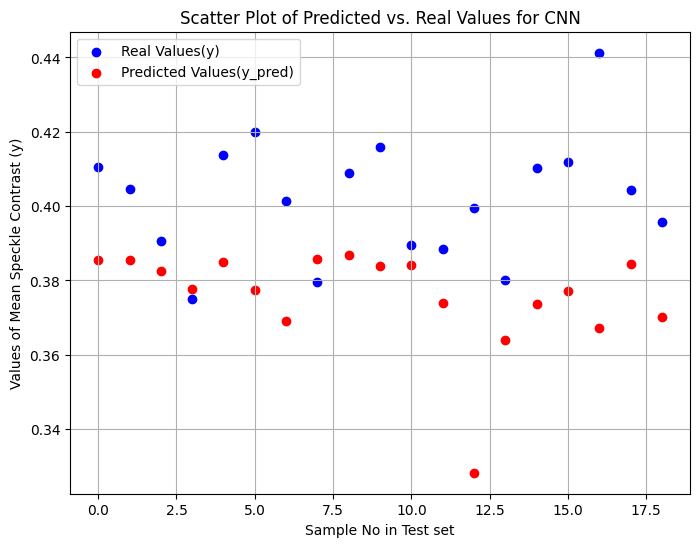

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Real Values(y)')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values(y_pred)')
plt.title('Scatter Plot of Predicted vs. Real Values for CNN')
plt.ylabel('Values of Mean Speckle Contrast (y)')
plt.xlabel('Sample No in Test set')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'Scatter_plot_C4_set2_center.png'))
plt.show()